# fdsreader Module

In order to analyse simulation data computed by FDS with Python, we have developed the Python module fdsreader. Its aim is to read most data output formats generated by FDS and map them to Python data structures.

It is freely available and open source. The source code is hosted at GitHub: [FireDynamics/fdsreader](https://github.com/FireDynamics/fdsreader) and there is also an [API documentation](https://firedynamics.github.io/fdsreader/index.html).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

import numpy as np

from IPython.display import display
from PIL import Image

## Installation

The fdsreader module can be installed via pip (see also the GitHub repository):

```
pip install fdsreader
```

However, it is already installed on all JupyterLab instances used for this lecture.

## Basic Demo Data Set

To demonstrate the usage of the fdsreader module, a simple FDS scenario ([Steckler compartment](../../examples/01_basic/02_basic_example_ii)) is utilized. Here, only a single mesh is used and only the fundamental data types are involved.

````{admonition} Full FDS input file
:class: tip, dropdown
```{literalinclude} data/fdsreader/example_01/example_01.fds
```
````

````{admonition} Precomputed simulation data
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fdsreader_example_01.zip)
````

### Open the Data Set

First the `fdsreader` module needs to be loaded:

In [2]:
import fdsreader

The version of (any) module can be checked with the `__version__` variable:

In [3]:
fdsreader.__version__

'1.9.1'

Next, the reader needs to be pointed to the directory, which contains the simulation data, especailly the smokeview file.

In [4]:
# define the path to the data
path_to_data = 'data/fdsreader/example_01/rundir'

sim = fdsreader.Simulation(path_to_data)

The `Simulation` object `sim` contains now all the information and data about the simulaiton output:

In [5]:
sim

Simulation(chid=StecklerExample,
           meshes=1,
           obstructions=4,
           slices=5,
           smoke_3d=3,
           devices=4)

The variable `sim` contains information about the mesh (`MESH`), four slices (`SLCF`) and four point measurements (`DEVC`). The additional device – there were just three defined in the FDS input file – is the time column. 

```{tip} You can use the autocomplete function in Jupyter. This way you can quickly see available data structures and functions, especially in complex data types as the Simulation object.
```

### Device Data

The simplest data set is the output of the `DEVC` directives. The available data and meta information can be directly printed:

In [6]:
# short reference for convinience, i.e. `devc` contains all devices
devc = sim.devices
print(devc)

[Device(id='Time', xyz=(0.0, 0.0, 0.0), quantity=Quantity('TIME')),
Device(id='Temp_Door_Low', xyz=(1.45, 0.05, 0.1), quantity=Quantity('TEMPERATURE')),
Device(id='Temp_Door_Mid', xyz=(1.45, 0.05, 1.0), quantity=Quantity('TEMPERATURE')),
Device(id='Temp_Door_High', xyz=(1.45, 0.05, 1.65), quantity=Quantity('TEMPERATURE'))]


The `Device` class contains all relevant information, see [device documentation](https://firedynamics.github.io/fdsreader/devc.html). 

In [7]:
for i in devc:
    print(f"ID: {i.id},\t quantity: {i.quantity_name}, \t position: {i.position}")

ID: Time,	 quantity: TIME, 	 position: (0.0, 0.0, 0.0)
ID: Temp_Door_Low,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 0.1)
ID: Temp_Door_Mid,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 1.0)
ID: Temp_Door_High,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 1.65)


```{tip} Autocomplete works also for the dictionary keys ;-)
```
Individual devices, including the time column, are accessable as dictironary entries using their `ID` as key. The data of each individual device (`Device.data`) is stored as a numpy array:

In [8]:
type(devc['Temp_Door_Mid'].data)

numpy.ndarray

The length matches the expected value, i.e. 1801, as the simulation time was $\mf 1800\ s$ and the divices were writen out every second, including the initial time step, here at $\mf t=0\ s$. 

In [9]:
len(devc['Time'].data)

1801

A raw look at the data (`Device.data`):

In [10]:
devc['Temp_Door_Mid'].data

array([ 20.      ,  20.002083,  20.034418, ..., 105.32822 , 114.82179 ,
       115.01705 ], dtype=float32)

The device data can be also visualised with matplotlib:

In [11]:
# create the plot
plt.plot(devc['Time'].data, devc['Temp_Door_High'].data)

# label the axes
plt.xlabel("time / s")
devc_id = devc['Temp_Door_High'].id
devc_q = devc['Temp_Door_High'].quantity_name
devc_u = devc['Temp_Door_High'].unit
plt.ylabel(f"{devc_q} ({devc_id}) / {devc_u}")

# add a grid
plt.grid()

# save output to file
plt.savefig('figs/device_demo_01.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-fdsreader-device-demo-plot-01

<img src="figs/device_demo_01.svg" width="80%">

Visualization of the data of one of the devices.
:::

In the same manner a set of devices can be plotted at once. Like all devices with names starting with `Temp_`:

In [12]:
# loop over all devices
for i in devc:
    
    # consider only devices with an ID that starts with 'Temp_'
    if not i.id.startswith('Temp_'): 
        continue
    
    plt.plot(devc["Time"].data, i.data, label=i.id)
    
plt.legend()
plt.xlabel("time / s")
plt.ylabel('temperature / $^\circ$C')
plt.grid()

# save output to file
plt.savefig('figs/device_demo_02.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-fdsreader-device-demo-plot-02

<img src="figs/device_demo_02.svg" width="80%">

Visualization of the data of a set of devices.
:::

### HRR Data

In the same fashion as the `DEVC` data, the data written to the `HRR` file can be directly accessed. It is not stored in the `devices` but in the `hrr` element of the `Simulation` object.

In [13]:
plt.plot(sim.hrr['Time'], sim.hrr['HRR'], label='heat release from fire')

plt.plot(sim.hrr['Time'], sim.hrr['Q_RADI'], label='radiative')
plt.plot(sim.hrr['Time'], sim.hrr['Q_COND'], label='conductive')
plt.plot(sim.hrr['Time'], sim.hrr['Q_CONV'], label='convective')

plt.plot(sim.hrr['Time'], 
         sim.hrr['HRR'] + sim.hrr['Q_RADI'] + sim.hrr['Q_COND'] + sim.hrr['Q_CONV'], 
         color='grey', label='sum', zorder=0)

plt.xlabel('time / s')
plt.ylabel('heat flow rate / kW')
plt.legend()

plt.grid()

# save output to file
plt.savefig('figs/hrr_demo_01.svg', bbox_inches='tight')
plt.close()


:::{figure-md} fig-fdsreader-hrr-demo-plot-01

<img src="figs/hrr_demo_01.svg" width="80%">

Visualization of a set of columns from the `HHR` file.
:::

### Slice Data

Data generated by `SLCF` directives span over two or three spatial dimensions plus the time dimension. Besides that, they can be distributed across multiple meshes. 

The data of a slice is stored for each mesh individually. In this simple example, there is only a single mesh, yet for formal consistency it still needs to be referred.

The data sturcutre is as follows

```
sim.slices[sliceid][meshid].data[timestep, direction1, direction2]
```

where `sliceid` is just the index of the slice, `meshid` is the index of the mesh, here in this example 0, and the reference to the data is given by the time step id and then the two spatial indices (for two dimensional slices).

In general there are multiple slice objects available:

In [14]:
# print available slice data
for slice in sim.slices:
    print(f"Slice Type [2D/3D]: {slice.type}\n  Quantity: {slice.quantity.name}\n", 
          f" Physical Extent: {slice.extent}\n  Orientation [1/2/3]: {slice.orientation}\n")

Slice Type [2D/3D]: 2D
  Quantity: TEMPERATURE
  Physical Extent: Extent([0.00, 0.00] x [-1.40, 1.40] x [0.00, 2.20])
  Orientation [1/2/3]: 1

Slice Type [2D/3D]: 2D
  Quantity: TEMPERATURE
  Physical Extent: Extent([-1.40, 2.60] x [0.00, 0.00] x [0.00, 2.20])
  Orientation [1/2/3]: 2

Slice Type [2D/3D]: 2D
  Quantity: W-VELOCITY
  Physical Extent: Extent([0.00, 0.00] x [-1.40, 1.40] x [0.00, 2.20])
  Orientation [1/2/3]: 1

Slice Type [2D/3D]: 2D
  Quantity: U-VELOCITY
  Physical Extent: Extent([-1.40, 2.60] x [0.00, 0.00] x [0.00, 2.20])
  Orientation [1/2/3]: 2

Slice Type [2D/3D]: 2D
  Quantity: W-VELOCITY
  Physical Extent: Extent([-1.40, 2.60] x [-1.40, 1.40] x [1.80, 1.80])
  Orientation [1/2/3]: 3



There are multiple ways to find the right slice in the set of all slices. One way is to filter for a quantity using the `filter_by_quantity` function or choose a slice by its ID.

In [15]:
# get the W-VELOCITY slice(s)
w_slice = sim.slices.filter_by_quantity("W-VELOCITY")
print(w_slice)

SliceCollection([Slice([2D] quantity=Quantity('W-VELOCITY'), cell_centered=False, extent=Extent([0.00, 0.00] x [-1.40, 1.40] x [0.00, 2.20]), extent_dirs=('y', 'z'), orientation=1),
Slice([2D] quantity=Quantity('W-VELOCITY'), cell_centered=False, extent=Extent([-1.40, 2.60] x [-1.40, 1.40] x [1.80, 1.80]), extent_dirs=('x', 'y'), orientation=3)])


Another way is to select a slice based on its distance to a given point.

In [16]:
# select slice, by its distance to a given point
slc = w_slice.get_nearest(x=1, z=2)
print(slc)

Slice([2D] quantity=Quantity('W-VELOCITY'), cell_centered=False, extent=Extent([-1.40, 2.60] x [-1.40, 1.40] x [1.80, 1.80]), extent_dirs=('x', 'y'), orientation=3)


To access the actual slice data, the actual mesh and a point in time needs to be specified. In this example, there is only one mesh, thus the index is 0. The function `get_nearest_timestemp` helps to find the right time index.

In [17]:
# choose and output the time step, next to t=75 s
it = slc.get_nearest_timestep(25)
print(f"Time step: {it}")
print(f"Simulation time: {slc.times[it]}")

Time step: 25
Simulation time: 25.02111


The following example illustrates the visualisation of the data and steps needed to adjust the representation. The needed adjustments are due to the data orientation expected by the `imshow` function.

In [18]:
# choose the temperature slice in y-direction
slc = sim.slices.filter_by_quantity('TEMPERATURE').get_nearest(x=3, y=0)
print(slc)
# only one mesh
slc_data = slc[0].data
print(slc_data)

Slice([2D] quantity=Quantity('TEMPERATURE'), cell_centered=False, extent=Extent([-1.40, 2.60] x [0.00, 0.00] x [0.00, 2.20]), extent_dirs=('x', 'z'), orientation=2)
[[[ 20.        20.        20.       ...  20.        20.        20.      ]
  [ 20.        20.        20.       ...  20.        20.        20.      ]
  [ 20.        20.        20.       ...  20.        20.        20.      ]
  ...
  [ 20.        20.        20.       ...  20.        20.        20.      ]
  [ 20.        20.        20.       ...  20.        20.        20.      ]
  [ 20.        20.        20.       ...  20.        20.        20.      ]]

 [[ 20.030926  20.031328  20.032204 ...  20.001385  20.001268  20.00117 ]
  [ 20.030703  20.031597  20.033634 ...  20.001493  20.001345  20.001238]
  [ 20.031723  20.033785  20.038801 ...  20.001757  20.001535  20.001389]
  ...
  [ 20.006077  20.004908  20.002953 ...  20.001383  20.001154  20.00104 ]
  [ 20.005085  20.004053  20.00236  ...  20.00129   20.001116  20.001026]
  [ 20.

In [19]:
# Initial visualasation of the data at time t=50 s
it = slc.get_nearest_timestep(50)
plt.imshow(slc_data[it]);

# save output to file
plt.savefig('figs/slice_imshow_01.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-slice-imshow-01

<img src="figs/slice_imshow_01.svg" width="80%">

Visualization of a slice.
:::

In [20]:
# Access the transpose data using ndarray.T and set the origin of the output
plt.imshow(slc_data[it].T, origin='lower');

# save output to file
plt.savefig('figs/slice_imshow_02.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-slice-imshow-02

<img src="figs/slice_imshow_02.svg" width="80%">

Visualization of a slice.
:::

In [24]:
# Finally, also the extend is specified to move from index to physical space
# Additionally, the maximal value is set using the vmax argument
plt.imshow(slc_data[it].T, 
           origin='lower',
           vmax=200,
           extent=slc.extent.as_list())
plt.colorbar(label='temperature / C', orientation='horizontal');
plt.xlabel('x coordinate / m')
plt.ylabel('z coordinate / m')

# save output to file
plt.savefig('figs/slice_imshow_03.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-slice-imshow-03

<img src="figs/slice_imshow_03.svg" width="80%">

Visualization of a slice.
:::

Obstructions can be visualised using masks, i.e. the data points which lie inside an obstacle will be marked non-valid as an not-a-number (nan) value.

In [35]:
# Example for a multi plot
list_t = [0, 50, 100, 200, 300, 400]
fig, axs = plt.subplots(2,3, sharex=True, sharey=True)
for i in range(len(list_t)):
    it = slc.get_nearest_timestep(list_t[i])
    axs.flat[i].imshow(slc_data[it].T,
                       vmin=20,
                       vmax=400,
                       origin='lower', 
                       extent=slc.extent.as_list())
    axs.flat[i].set_title(f"t={slc.times[it]:.1f}")
    
# save output to file
plt.savefig('figs/slice_imshow_04.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-slice-imshow-04

<img src="figs/slice_imshow_04.svg" width="80%">

Visualization of a slice.
:::

In [36]:
# Example for a plot of all slice quantities at a given point in time
it = sim.slices[0].get_nearest_timestep(100)
fig_count=0
for slc in sim.slices:
    plt.imshow(slc[0].data[it].T,
               origin='lower', 
               extent=slc.extent.as_list())
    q = slc.quantity.quantity
    u = slc.quantity.unit
    plt.xlabel(f'{slc.extent_dirs[0]} / m')
    plt.ylabel(f'{slc.extent_dirs[1]} / m')
    plt.colorbar(label=f"{q} / {u}")
    # save output to file
    plt.savefig(f'figs/slice_multi_{fig_count:02d}.svg', bbox_inches='tight')
    fig_count += 1
    plt.close()

:::{figure-md} fig-fdsreader-slice-multi-01

<img src="figs/slice_multi_00.svg" width="80%">

Visualization of a slice.
:::

:::{figure-md} fig-fdsreader-slice-multi-02

<img src="figs/slice_multi_01.svg" width="80%">

Visualization of a slice.
:::

:::{figure-md} fig-fdsreader-slice-multi-03

<img src="figs/slice_multi_02.svg" width="80%">

Visualization of a slice.
:::

:::{figure-md} fig-fdsreader-slice-multi-04

<img src="figs/slice_multi_03.svg" width="80%">

Visualization of a slice.
:::

:::{figure-md} fig-fdsreader-slice-multi-05

<img src="figs/slice_multi_04.svg" width="80%">

Visualization of a slice.
:::

## Advanced Demo

In contrast to the above example, the computational domain is split into two meshes.

````{admonition} Full FDS input file
:class: tip, dropdown
```{literalinclude} data/fdsreader/example_02/example_02.fds
```
````

````{admonition} Precomputed simulation data
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fdsreader_example_02.zip)
````

In [37]:
# define the path to the data
path_to_data = 'data/fdsreader/example_02/rundir'

sim = fdsreader.Simulation(path_to_data)
print(sim)

Simulation(chid=StecklerExample,
           meshes=2,
           obstructions=4,
           slices=5,
           smoke_3d=3,
           devices=4)


### Multi Mesh Slices

First, one of the slices is selected, e.g. the temperature slice normal to y

In [38]:
slc = sim.slices.filter_by_quantity('TEMPERATURE').get_nearest(x=2, y=0)
print(slc)

Slice([2D] quantity=Quantity('TEMPERATURE'), cell_centered=False, extent=Extent([-1.40, 2.60] x [0.00, 0.00] x [0.00, 2.20]), extent_dirs=('x', 'z'), orientation=2)


Each slice records in which meshes it is present. In this case, these are just two. 

In [39]:
slc.meshes

[Mesh(id="Domain_A", extent=Extent([-1.40, 0.60] x [-1.40, 1.40] x [0.00, 2.20]), dimension=Dimension(21, 29, 23)),
 Mesh(id="Domain_B", extent=Extent([0.60, 2.60] x [-1.40, 1.40] x [0.00, 2.20]), dimension=Dimension(21, 29, 23))]

The data strucutre of a slice is, that it consists of a set of sub-slices, one for each mesh. These are of variable size, depending on the mesh structure. The sub-slices can be individually accessed.

In [40]:
for m in slc.meshes:
    print(slc.get_subslice(m))

SubSlice(shape=(21, 23), mesh=Domain_A, extent=Extent([-1.40, 0.60] x [0.00, 0.00] x [0.00, 2.20]))
SubSlice(shape=(21, 23), mesh=Domain_B, extent=Extent([0.60, 2.60] x [0.00, 0.00] x [0.00, 2.20]))


In [69]:
it = slc.get_nearest_timestep(100)
fig, axs = plt.subplots(1,2)
ax_count=0
for m in slc.meshes:
    s = slc.get_subslice(m)
    axs.flat[ax_count].imshow(s.data[it].T, 
                              origin='lower', 
                              extent=s.extent.as_list(),
                              vmax=200)
    axs.flat[ax_count].set_xlabel(f'{slc.extent_dirs[0]} / m')
    axs.flat[ax_count].set_ylabel(f'{slc.extent_dirs[1]} / m')
    ax_count += 1

plt.tight_layout()
# save output to file
plt.savefig('figs/multi_slice_separate.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-multi-slice-separate

<img src="figs/multi_slice_separate.svg" width="80%">

Individual visualization of slices on two meshes.
:::

In order to merge the subslices, the `to_global` function can be used. 

In [43]:
gslice, gcoord = slc.to_global(return_coordinates=True)
print(type(gslice))
print(gslice.shape)

<class 'numpy.ndarray'>
(1801, 41, 23)


The resulting data structure can now be used the same way as the one mesh slices. Yet, the meta data needs to be drawn from the original slice object, as the result of `to_global` is a plain numpy array.

In [67]:
plt.imshow(gslice[it].T, 
           origin='lower', 
           extent=slc.extent.as_list(),
           vmax=200)
plt.xlabel(f'{slc.extent_dirs[0]} / m')
plt.ylabel(f'{slc.extent_dirs[1]} / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}')

# save output to file
plt.savefig('figs/multi_slice_global.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-fdsreader-multi-slice-global

<img src="figs/multi_slice_global.svg" width="80%">

Visualization of a global, i.e. merged, slice.
:::

### Accessing Slice Data

The data of a slice can be accessed to extract various subsets of data. For example, to create a temperature and x-velocity profile at a given time across the door (in z-direction) can be achieved with the following code.

In [45]:
# get the slice data as global objects
u_slice = sim.slices.filter_by_quantity('U-VELOCITY').get_nearest(x=2, y=0).to_global()
t_slice = sim.slices.filter_by_quantity('TEMPERATURE').get_nearest(x=2, y=0).to_global()

In [46]:
# define the time index
it = sim.slices[0].get_nearest_timestep(100)

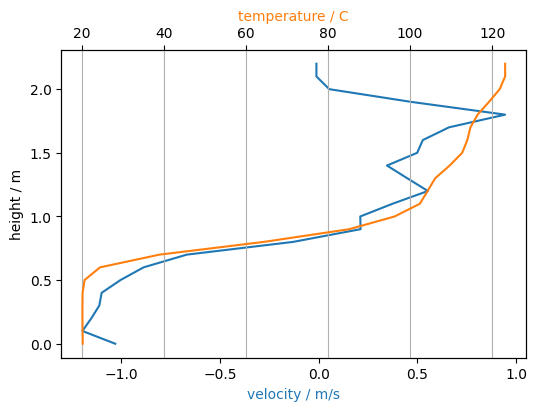

In [61]:
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

# select spatial index (ix) based on physical position (x0)
x0 = 1.25
ix = np.where(gcoord['x'] >= x0)[0][0]

ax1.plot(u_slice[it][ix,:], gcoord['z'], label='x-velocity', color='C0')
ax2.plot(t_slice[it][ix,:], gcoord['z'], label='temperature', color='C1')
ax1.set_xlabel('velocity / m/s', color='C0')
ax2.set_xlabel('temperature / C', color='C1')
ax1.set_ylabel('height / m')
plt.grid()

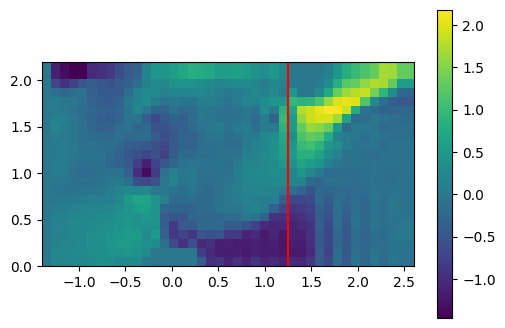

In [62]:
# illustrate the location of the extracted data
plt.imshow(u_slice[it].T, 
           origin='lower',
           extent=slc.extent.as_list())
plt.axvline(x=x0, color='red')
plt.colorbar();

The time evolution of a quantity at a given location is accessed in a similar way.

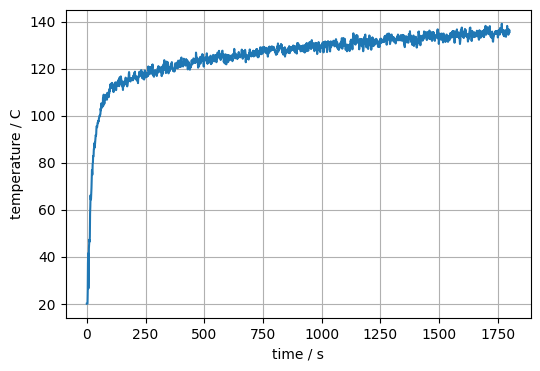

In [63]:
# select spatial index
x0 = 1.25
z0 = 1.50
ix = np.where(gcoord['x'] > x0)[0][0]
iy = np.where(gcoord['z'] > z0)[0][0]

plt.plot(slc.times, t_slice[:, ix, iy])
plt.xlabel('time / s')
plt.ylabel('temperature / C')
plt.grid()

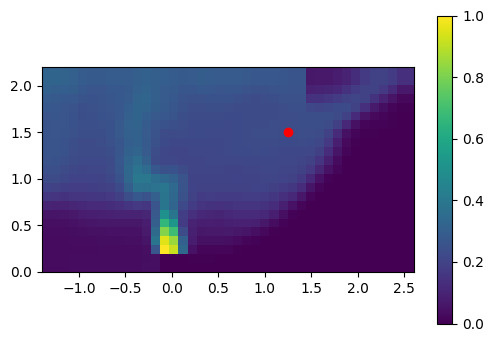

In [64]:
# illustrate the location of the extracted data
plt.imshow(t_slice[it].T, 
           origin='lower',
           extent=slc.extent.as_list())
plt.scatter(x0, z0, color='red')
plt.colorbar();

### Boundary Data

In a similar manner as the slice data, the boudary data of obstructions can be accessed. As this data is bound to an obstruction in FDS, it is part of each individual obstruction object. 

In [37]:
sim.obstructions

ObstructionCollection([Obstruction(id=1, Bounding-Box=Extent([-0.20, 0.20] x [-0.20, 0.20] x [0.00, 0.20]), SubObstructions=1),
Obstruction(id=2, Bounding-Box=Extent([-1.40, 1.51] x [-1.40, 1.40] x [2.20, 2.20]), SubObstructions=2, Quantities=['temp']),
Obstruction(id=4, Bounding-Box=Extent([-1.40, 1.40] x [1.40, 1.40] x [0.00, 2.20]), SubObstructions=2, Quantities=['temp']),
Obstruction(id=3, Bounding-Box=Extent([1.41, 1.51] x [-0.20, 0.20] x [0.00, 0.00]), SubObstructions=1)])

In [38]:
for o in sim.obstructions:
    print(f'ID: {o.id}; has data: {o.has_boundary_data}')
    if o.has_boundary_data:
        print(f'  orientations: {o.orientations}')
        print(f'  quantities: {o.quantities}')
        print(f'  number of involved meshes: {len(o.meshes)}')

ID: 1; has data: False
ID: 2; has data: True
  orientations: [-3]
  quantities: [Quantity('WALL TEMPERATURE')]
  number of involved meshes: 2
ID: 4; has data: True
  orientations: [-2]
  quantities: [Quantity('WALL TEMPERATURE')]
  number of involved meshes: 2
ID: 3; has data: False


Let's select the boundary at the ceiling, i.e. the one with orientation `-3`.

In [39]:
obst = sim.obstructions.get_by_id(2)
print(obst)

Obstruction(id=2, Bounding-Box=Extent([-1.40, 1.51] x [-1.40, 1.40] x [2.20, 2.20]), SubObstructions=2, Quantities=['temp'])


The time step index and the global, due to multiple meshes involved, data structure. The function `get_global_boundary_data_arrays` needs the quantity and the orientation to create a numpy data object.

In [40]:
obst = sim.obstructions[1]
it = obst.get_nearest_timestep(100)
data = obst.get_global_boundary_data_arrays('WALL TEMPERATURE')[-3]
print(f'shape of the data object: {data.shape}')

shape of the data object: (1801, 29, 28)


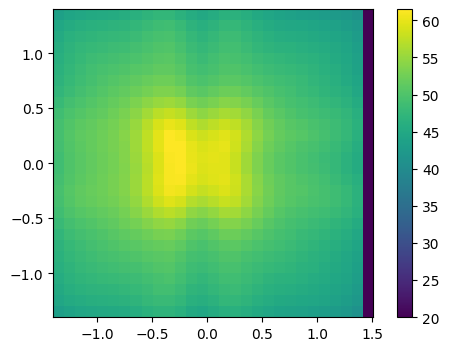

In [41]:
plt.imshow(data[it].T, 
           origin='lower', extent=obst.bounding_box.as_list())
plt.colorbar()

In the same mannor as above, e.g. time series at a given point on the boundary can be created. For a point at the center of the boundary, this could be something like this:

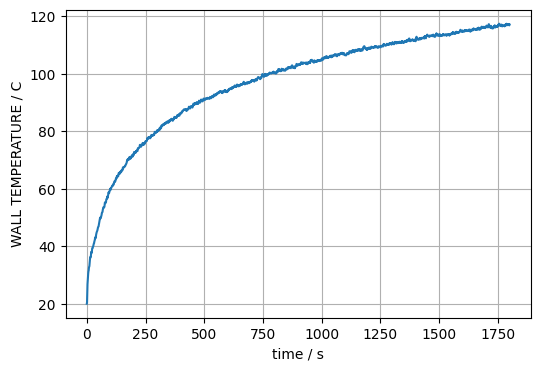

In [42]:
ix = data.shape[1] // 2
iy = data.shape[2] // 2

plt.plot(obst.times, data[:, ix, iy])
plt.xlabel('time / s')
plt.ylabel(f'{obst.quantities[0].name} / {obst.quantities[0].unit}')
plt.grid()